# V2X 데이터 정보

In [1]:
import numpy as np
import cv2
import torch
import pandas as pd
import re
import pickle as pkl
import json
import glob
import shutil
import os
import json
import pathlib as pl
from typing import List, Tuple, Dict, Union, Optional
from tqdm import trange, tqdm
from glob import glob
from collections import Counter
from sklearn.model_selection import train_test_split

from preprocessing import V2XPreprocessing
from modules.v2x import V2XData,V2XDataLabeled
from tsai.all import *
from tqdm import tqdm
from modules.RunTSAI import RunTSAI
from sklearn.utils import shuffle

data_path_8 = "/data/NIA50/50-1/data/v2xfinal/8월"
data_path_8s = "/data/NIA50/50-1/data/v2xfinal/8월세종"
data_path_9 = "/data/NIA50/50-1/data/v2xfinal/9월"
data_path_10 = "/data/NIA50/50-1/data/v2xfinal/10월"
data_path_11 = "/data/NIA50/50-1/data/v2xfinal/11월"

## CSV, JSON 파일 경로 리스트 만들기
- CSV, JSON 파일을 한 경로에 담기
  - 8월
  -  ㄴ CSV
  -  ㄴ JSON
  - 9월
  -  ㄴ CSV
  -  ㄴ JSON

In [3]:
# csv파일과 json파일을 각각 리스트로 가져옴
csv_files8, json_files8 = V2XPreprocessing.get_csv_data(data_path_8 + "/CSV"), \
                            V2XPreprocessing.get_json_data(data_path_8 + "/JSON")
print(f"csv file count: {len(csv_files8)}, json file count: {len(json_files8)}")

csv file count: 930000, json file count: 930000


In [2]:
# csv파일과 json파일 각 리스트를 pickle로 가져옴
with open("pickles/CSV8.pkl", "rb") as f:
    csv_files8 = pkl.load(f)
with open("pickles/JSON8.pkl", "rb") as f:
    json_files8 = pkl.load(f)

In [4]:
# csv파일과 json파일 리스트를 pickle로 저장
with open("pickles/CSV8.pkl", "wb") as f:
    pkl.dump(csv_files8, f)
with open("pickles/JSON8.pkl", "wb") as f:
    pkl.dump(json_files8, f)

In [3]:
# CSV파일 concat, pickle로 저장
df8 = [pd.read_csv(f) for f in tqdm(csv_files8, desc="Reading csv files")]
df8 = pd.concat(df8, ignore_index=True)
with open("pickles/df8.pkl", "wb") as f:
    pkl.dump(df8, f)

Reading csv files: 100%|██████████| 930000/930000 [46:46<00:00, 331.40it/s]  


In [3]:
# CSV파일 concat pickle로 가져옴
with open("pickles/df8csv.pkl", "rb") as f:
    df8csv = pkl.load(f)

In [4]:
df8csv.head()

,ISSUE_DATE,VEHICLE_ID,VEHICLE_CLASS,LONGITUDE,LATITUDE,HEADING,SPEED,BRAKE_STATUS,ACC_SEC,VEHICLE_TYPE
0,2.022080e+13,FFE809B4,9228,126.911982,35.178808,175,0.0,0.0,0.0,bus
1,2.022080e+13,FFE809B4,9228,126.911983,35.178803,175,3.0,0.0,83.0,bus
2,2.022080e+13,FFE809B4,9228,126.911985,35.178789,170,6.0,0.0,83.0,bus
3,2.022080e+13,FFE809B4,9228,126.911989,35.178767,173,10.0,0.0,111.0,bus
4,2.022080e+13,FFE809B4,9228,126.911994,35.178739,168,11.0,0.0,28.0,bus


In [6]:
# NaN값 제거
df8csv = df8csv.dropna()
# counts rows if there's NaN value
df8csv.isna().sum()

In [13]:
for col in df8csv.columns:
    if col in ["VEHICLE_ID", "VEHICLE_TYPE"]:
        continue
    # print if value is not float or int
    print(f"{col}: {df8csv[col].apply(lambda x: type(x) not in [float, int]).sum()}")

VEHICLE_CLASS: 0
LONGITUDE: 0
LATITUDE: 0
HEADING: 0
SPEED: 0
BRAKE_STATUS: 0
ACC_SEC: 0


In [12]:
# exclude ["ISSUE_DATE"] column, values to int on ["VEHICLE_CLASS", "HEADING"], str on ["VEHICLE_ID", "VEHICLE_TYPE"], float on others

for col in df8csv.columns:
    if col in ["ISSUE_DATE"]:
        df8csv.drop(col, axis=1, inplace=True)
    elif col in ["VEHICLE_CLASS", "HEADING"]:
        df8csv[col] = df8csv[col].astype(int)
    elif col in ["VEHICLE_ID", "VEHICLE_TYPE"]:
        df8csv[col] = df8csv[col].astype(str)
    else:
        df8csv[col] = df8csv[col].astype(float)

In [21]:
# value counts of VEHICLE_ID VEHICLE_CLASS VEHICLE_TYPE
for col in df8csv.columns:
    if col in ["VEHICLE_ID", "VEHICLE_CLASS", "VEHICLE_TYPE"]:
        print(f"{col}: {df8csv[col].value_counts()}")
        print(f"{col} unique: {df8csv[col].unique().shape}", end="\n\n")

VEHICLE_ID: FFE80A2F    14400
FFE80BD4    14400
FFE80C9A    13800
FFE809EA    13200
FFE80C80    13000
            ...  
FFE80F35      200
FFE80FAD      200
FFE80E9C      200
FFE81156      200
FFE80D08      200
Name: VEHICLE_ID, Length: 1691, dtype: int64
VEHICLE_ID unique: (1691,)

VEHICLE_CLASS: 9228    6918288
9220    2141712
9736     109800
9741      71000
9230      39200
9240      15000
9734       5000
Name: VEHICLE_CLASS, dtype: int64
VEHICLE_CLASS unique: (7,)

VEHICLE_TYPE: bus        6917710
car        2141400
special     239980
none           910
Name: VEHICLE_TYPE, dtype: int64
VEHICLE_TYPE unique: (4,)



In [23]:
# categorize ["VEHICLE_ID", "VEHICLE_CLASS", "VEHICLE_TYPE"] columns
from sklearn.preprocessing import LabelEncoder

for col in df8csv.columns:
    if col in ["VEHICLE_ID", "VEHICLE_CLASS", "VEHICLE_TYPE"]:
        encoder = LabelEncoder()
        encoder.fit(df8csv[col])
        categorized_array = encoder.transform(df8csv[col])
        print(categorized_array)
        df8csv[col] = categorized_array

[  20   20   20 ... 1689 1689 1689]
[1 1 1 ... 1 1 1]
[0 0 0 ... 0 0 0]


In [26]:
# index reset
df8csv.reset_index(drop=True, inplace=True)
df8csv

,VEHICLE_ID,VEHICLE_CLASS,LONGITUDE,LATITUDE,HEADING,SPEED,BRAKE_STATUS,ACC_SEC,VEHICLE_TYPE
0,20,1,126.911982,35.178808,175,0.0,0.0,0.0,0
1,20,1,126.911983,35.178803,175,3.0,0.0,83.0,0
2,20,1,126.911985,35.178789,170,6.0,0.0,83.0,0
3,20,1,126.911989,35.178767,173,10.0,0.0,111.0,0
4,20,1,126.911994,35.178739,168,11.0,0.0,28.0,0
...,...,...,...,...,...,...,...,...,...
9299995,1689,1,126.831621,35.140219,199,23.0,0.0,28.0,0
9299996,1689,1,126.831594,35.140158,199,25.0,0.0,56.0,0
9299997,1689,1,126.831569,35.140100,200,28.0,0.0,56.0,0
9299998,1689,1,126.831538,35.140030,199,30.0,0.0,56.0,0


# Standarization

In [27]:
# standardize
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df8csv_scaled = scaler.fit_transform(df8csv)
df8csv_scaled = pd.DataFrame(df8csv_scaled, columns=df8csv.columns)
df8csv_scaled

,VEHICLE_ID,VEHICLE_CLASS,LONGITUDE,LATITUDE,HEADING,SPEED,BRAKE_STATUS,ACC_SEC,VEHICLE_TYPE
0,-1.550767,0.174339,0.341612,0.231411,0.076075,-0.820874,-0.889207,-0.002804,-0.50743
1,-1.550767,0.174339,0.341621,0.231329,0.076075,-0.666876,-0.889207,1.708823,-0.50743
2,-1.550767,0.174339,0.341641,0.231122,0.030177,-0.512877,-0.889207,1.708823,-0.50743
3,-1.550767,0.174339,0.341673,0.230795,0.057716,-0.307547,-0.889207,2.286239,-0.50743
4,-1.550767,0.174339,0.341718,0.230371,0.011818,-0.256214,-0.889207,0.574612,-0.50743
...,...,...,...,...,...,...,...,...,...
9299995,2.121939,0.174339,-0.351603,-0.350220,0.296383,0.359778,-0.889207,0.574612,-0.50743
9299996,2.121939,0.174339,-0.351836,-0.351132,0.296383,0.462443,-0.889207,1.152029,-0.50743
9299997,2.121939,0.174339,-0.352056,-0.352014,0.305563,0.616441,-0.889207,1.152029,-0.50743
9299998,2.121939,0.174339,-0.352317,-0.353069,0.296383,0.719107,-0.889207,1.152029,-0.50743


# CSV 파일 Dataframe pickle로 저장

In [28]:
with open("pickles/df8_scaled.pkl", "wb") as f:
    pkl.dump(df8csv_scaled, f)

In [50]:
df8csv_scaled = pd.read_pickle("pickles/df8_scaled.pkl") # load pickle

In [51]:
# reshape 9300000 rows × 9 columns to 930000 rows x 9 columns x 10, and changed to numpy array
df8csv_scaled_npy = df8csv_scaled.values.reshape(930000, 10, 9)
df8csv_scaled_npy = df8csv_scaled_npy.transpose(0, 2, 1)

In [57]:
# save numpy array as npy file
np.save("pickles/X_8.npy", df8csv_scaled_npy)

In [33]:
print(df8csv_scaled.shape)
df8csv_scaled[:10]


(930000, 9, 10)


array([[[-1.55076738e+00,  1.74339069e-01,  3.41612369e-01,
          2.31411417e-01,  7.60749122e-02, -8.20873533e-01,
         -8.89206574e-01, -2.80372603e-03, -5.07429897e-01,
         -1.55076738e+00],
        [ 1.74339069e-01,  3.41620995e-01,  2.31328520e-01,
          7.60749122e-02, -6.66875507e-01, -8.89206574e-01,
          1.70882291e+00, -5.07429897e-01, -1.55076738e+00,
          1.74339069e-01],
        [ 3.41640835e-01,  2.31122029e-01,  3.01773071e-02,
         -5.12877480e-01, -8.89206574e-01,  1.70882291e+00,
         -5.07429897e-01, -1.55076738e+00,  1.74339069e-01,
          3.41672753e-01],
        [ 2.30794960e-01,  5.77158701e-02, -3.07546777e-01,
         -8.89206574e-01,  2.28623912e+00, -5.07429897e-01,
         -1.55076738e+00,  1.74339069e-01,  3.41718472e-01,
          2.30371428e-01],
        [ 1.18182651e-02, -2.56214101e-01, -8.89206574e-01,
          5.74612488e-01, -5.07429897e-01, -1.55076738e+00,
          1.74339069e-01,  3.41759016e-01,  2.298815

----------------------

# JSON

In [5]:
with open("pickles/8월/JSON8.pkl", "rb") as f:
    json_files8 = pkl.load(f)

In [8]:
# read json_file8[0]
with open(json_files8[0], "r") as f:
    json_sample = json.load(f)
json_sample

{'Path': 'V_220801_C_A_FFE809B4_000075.csv',
 'Annotation': {'Vehicle_ID': 'FFE809B4',
  'Turn': 'False',
  'Lane': 'False',
  'Speed': 'False',
  'Hazard': 'False'}}

In [59]:
df8_json = pd.read_json(json_files8[0])
# df8_json = df8_json['Annotation'][['Turn', 'Lane', 'Speed', 'Hazard']].to_frame().T
# values = df8_json.values.tolist()[0]
# values
df8_json

,Path,Annotation
Hazard,V_220801_C_A_FFE809B4_000075.csv,False
Lane,V_220801_C_A_FFE809B4_000075.csv,False
Speed,V_220801_C_A_FFE809B4_000075.csv,False
Turn,V_220801_C_A_FFE809B4_000075.csv,False
Vehicle_ID,V_220801_C_A_FFE809B4_000075.csv,FFE809B4


In [38]:
json8_list = [pd.read_json(f, orient='index') for f in json_files8]

In [74]:
json8_list = []
cols = ['Turn', 'Lane', 'Speed', 'Hazard']
print(cols)

df8json = pd.DataFrame(columns=cols)
for i in trange(len(json_files8)):
    with open(json_files8[i], "r") as f:
        temp_json = json.load(f)
        temp_json = [temp_json['Annotation'][key][:4] for key in temp_json['Annotation'].keys() if key in cols]
        json8_list.append(temp_json)
        
# json8_list = [x[:4] for x in json8_list]
json8_npy = np.array(json8_list)

['Turn', 'Lane', 'Speed', 'Hazard']


100%|██████████| 930000/930000 [22:29<00:00, 689.06it/s] 


In [2]:
json8_npy = np.load("pickles/8월/y_8.npy")
json8_npy.shape

(930000, 4)

# Time series classification

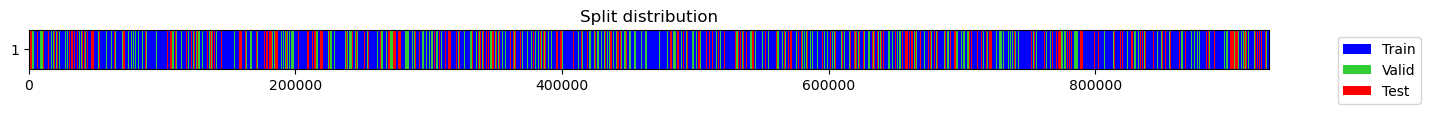

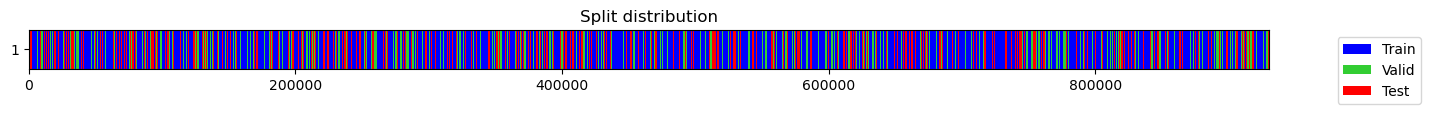

((#558000) [504217,123950,201829,737742,600295,677638,116658,244216,290502,37813...],
 (#186000) [670621,83240,310164,803634,377505,22242,484729,340222,677143,454159...],
 (#186000) [673273,743799,226544,585631,143343,324587,227962,263717,33676,336090...])

In [7]:
from tsai.all import *
config = AttrDict(
    batch_tfms = TSStandardize(by_sample=True),
    arch_config = {},
    architecture = LSTM, # LSTM, MLSTM_Plus
    lr = 1e-3,
    n_epochs = 200,
)

split_all = get_splits(json8_npy, shuffle=True, valid_size=0.2, test_size=0.2, random_state=42)
split_turn = get_splits(json8_npy[:, 0], shuffle=True, valid_size=0.2, test_size=0.2, random_state=42)

X = np.load("pickles/8월/X_8.npy")
y = np.load("pickles/8월/y_8.npy")
split = split_all

In [ ]:
# learner_turn = RunTSAI.multivariate_classification(X, y, split, config)
# curr_time = datetime.now().strftime("%Y%m%d_%H%M")
# learner_turn.save_all(path=f"models/turn_{curr_time}", dls_fname='dls_turn', model_fname='model_turn_MLSTM_FCNPlus', learner_fname='learner_turn')

In [12]:
tfms = [None, [TSCategorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=split, inplace=True)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=256, shuffle_train=False, batch_tfms=[TSStandardize()])

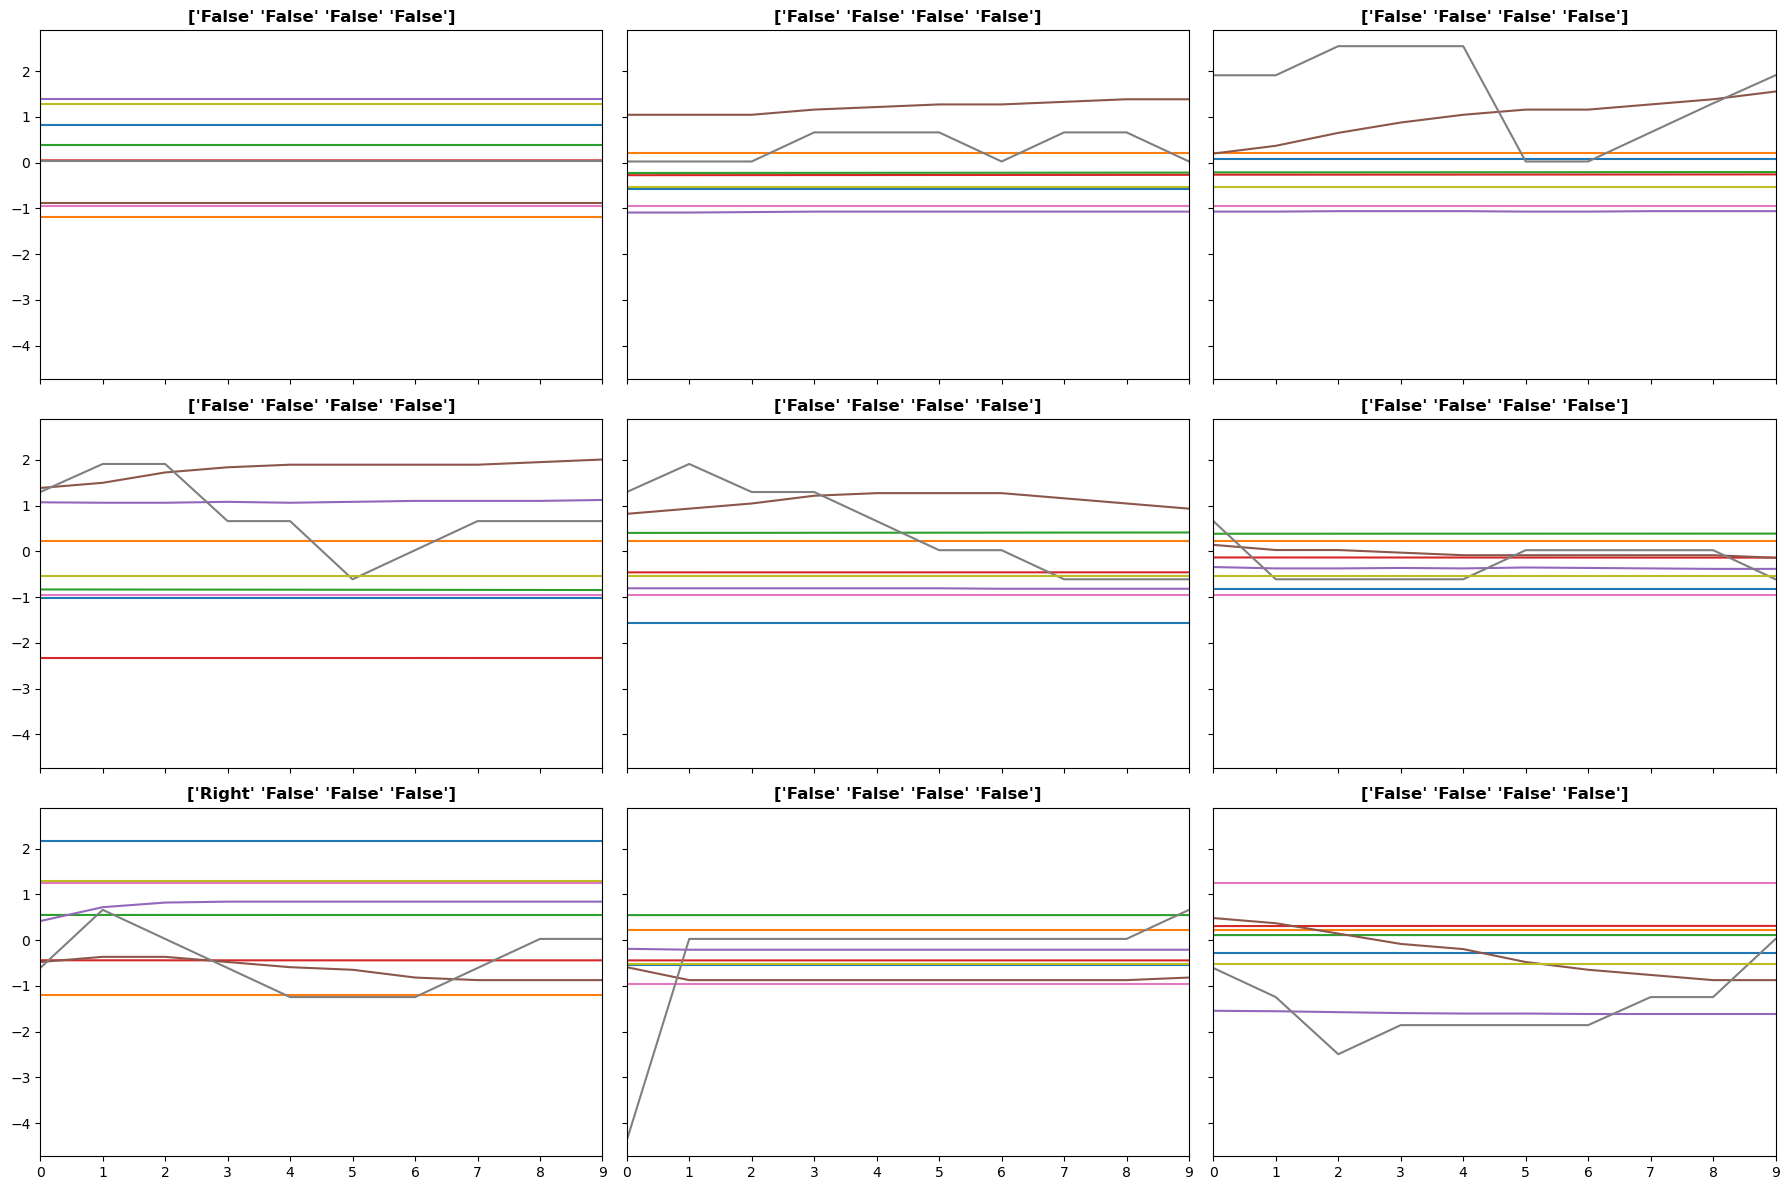

In [13]:
dls.show_batch(sharey=True)

In [11]:
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)
learn.lr_find(suggestions=F)

ValueError: Expected input batch_size (64) to match target batch_size (256).

-------------------

In [3]:
# csv_list, json_list = list(V2XPreprocessing.get_file_list(csv_path)) # csv, json 파일 리스트 만들기
def get_file_list_pickle() -> Tuple[List[str], List[str]]: # csv, json 파일 리스트 불러오기
    with open("./pickles/8월json.pkl", "rb") as f:
        json_list = pkl.load(f)
    with open("./pickles/8월csv.pkl", "rb") as f:
        csv_list = pkl.load(f)
    
    return csv_list, json_list

#   
def mk_traindata(data_path):
    conditions = ["turn", "lane", "speed", "hazard"]
    
    # X_sum, y_sum = empty numpy array
    X_sum = np.empty((0, 50, 1))
    y_sum = np.empty((0, 1))
    
    for cond in range(4): # 4 conditions
        v2xdata_ = V2XDataLabeled(data_path, condition = conditions[cond]) # load data scenarios
        for idx in range(len(v2xdata_)):
            X, y, _, df = v2xdata_[idx]
            X_sum = np.concatenate((X_sum, X), axis=0) if X_sum.size else X
            y_sum = np.concatenate((y_sum, y), axis=0) if y_sum.size else y
        splits = V2XDataLabeled.get_splits(None,X_sum, test_size = 0.2)
    
    print(X_sum.shape, y_sum.shape)
    print(splits[0][:10], splits[1][:10])
    
    return X_sum, y_sum, splits

def mk_X_npy(csv_path: List):
    pass


In [4]:
csv_list, json_list = list(get_file_list_pickle())
csv_list.sort(), json_list.sort()
print(f"csv file count: {len(csv_list)}, json file count: {len(json_list)}")

csv file count: 930000, json file count: 930000


In [5]:
csv_files[:3], json_files[:3]

NameError: name 'csv_files' is not defined

In [ ]:
EXCEPTION_COL = ["ISSUE_DATE", "VEHICLE_ID", "LONGITUDE", "LATITUDE"]

# X_sum = empty numpy array
X_sum = np.empty((0, 50, 1))

for csv in tqdm(csv_files):
    df = pd.read_csv(csv)
    df = df.drop(columns=EXCEPTION_COL)
    df = df.dropna()
    df = df.reset_index(drop=True)
    df = df.astype(np.float32)
    df = df.values
    df = df.reshape(1, 50, 1)
    X_sum = np.concatenate((X_sum, df), axis=0) if X_sum.size else df

In [12]:
EXCEPTION_COL = ["ISSUE_DATE", "VEHICLE_ID", "LONGITUDE", "LATITUDE"]

COLS = pd.read_csv(csv_files[0]).columns
X_sum = pd.DataFrame()
for csv in tqdm(csv_files):
    df = pd.read_csv(csv, usecols=list(set(COLS) - set(EXCEPTION_COL)))
    df = df.dropna()
    df = df.astype(np.float32)
    X_sum = pd.concat((X_sum, df)) if X_sum.size else df
X_sum = X_sum.values.reshape(-1, 50, 1)


  0%|          | 0/930000 [00:00<?, ?it/s]


ValueError: could not convert string to float: 'car'